In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import random

from dataset import Tokenizer, build_names_dataset, TensorDataset
from lr_scheduler import ConstatntLr
from optim import SgdOptimizer
from train import train_step, train
from layers import Linear, LinearNormalized, LinearWithGain, Tanh
from plot_activations import plot_initialization_statistics
from model import MultiLayerPerceptron

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Dataset preparation

The token we work with is a single character (for simplicity).
Our model will train to predict next token given previous context of 3 tokens (3-grams)

In [3]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
for name in names[:5]:
    print(name)
print(f'total names count: {names_cnt}')

# building vocabulary and tokenizer
special_tokens = ['.']   # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
tokenizer = Tokenizer(vocab)
print(f'{vocab=}')
print(f'{vocab_size=}')
print(tokenizer.encode("vlad"), tokenizer.decode([22,12,1,4]))

block_size = 3 # represents the length of context
random.shuffle(names)
train_bound = int(0.8*names_cnt)
val_bound   = int(0.9*names_cnt)
train_X, train_y = build_names_dataset(names[:train_bound], tokenizer, block_size)
val_X, val_y = build_names_dataset(names[train_bound:val_bound], tokenizer, block_size)
test_X, test_y = build_names_dataset(names[val_bound:], tokenizer, block_size)
print(f'{train_X.shape=}, {train_y.shape=}, {val_X.shape=}, {val_y.shape=}, {test_X.shape=}, {test_y.shape=}')
print("train:")
for i in range(13):
    print(f'{"".join(tokenizer.decode(train_X[i]))} => {tokenizer.itoc[train_y[i]]}')

train_ds = TensorDataset(train_X, train_y)
val_ds   = TensorDataset(val_X, val_y, device)

names:
emma
olivia
ava
isabella
sophia
total names count: 32033
vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size=27
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
train_X.shape=torch.Size([182479, 3]), train_y.shape=torch.Size([182479]), val_X.shape=torch.Size([22893, 3]), val_y.shape=torch.Size([22893]), test_X.shape=torch.Size([22774, 3]), test_y.shape=torch.Size([22774])
train:
... => a
..a => n
.an => d
and => r
ndr => o
dro => m
rom => e
ome => d
med => a
eda => .
... => q
..q => u
.qu => i


### Define evaluation

In [4]:
@torch.no_grad()
def evaluate(model, max_new_tokens=100):
    result = []
    context = torch.zeros((1, block_size)).to(torch.int64)
    for t in range(max_new_tokens):
        next_token = torch.multinomial(F.softmax(model(context), dim=1), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context = context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

def print_samples(model, tokenizer, n_samples=5):
    print('\nsamples:')
    trained_samples = []
    for i in range(n_samples):
        trained_samples.append(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))
    print(','.join(trained_samples))

### Build multi-layer perceptron (MLP) model

here we are building something like "Bengio et al. 2003 A Neural Probabilistic Language Model" paper

model.nelement()=4433
init_t_loss=19.209741592407227, init_v_loss=19.19997215270996
epoch=0: cur_avg_train_loss=2.7774795027969597, cur_val_loss=2.61010479927063
epoch=1: cur_avg_train_loss=2.553531318944768, cur_val_loss=2.5134449005126953
epoch=2: cur_avg_train_loss=2.5206648619613006, cur_val_loss=2.520817279815674
epoch=3: cur_avg_train_loss=2.4972452224136905, cur_val_loss=2.506849765777588
epoch=4: cur_avg_train_loss=2.4715055881843995, cur_val_loss=2.4471209049224854

samples:
iri.,numha.,emierlan.,trawdi.,ayip.,satthiisnasiakahieo.,ralona.,kartra.,irli.,aztoegiaya.,ocieg.,hhellanana.,elly.,tajiniastira.,tethana.


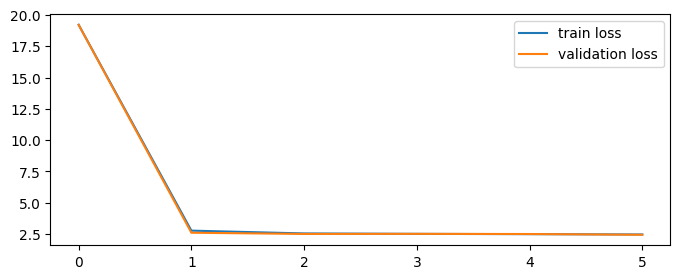

In [31]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=2, hidden_size=128, n_hidden=1, device=device)
lr_provider = ConstatntLr(0.1)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=5, batch_size=64, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

- initial loss too high
- after 5 iterations samples are bad

### Visualize 2D embeddings

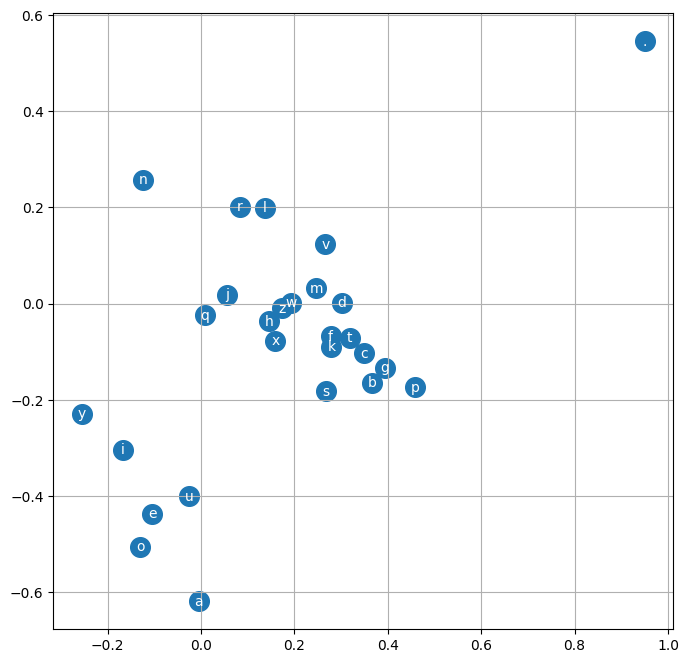

In [26]:
# visualize dimensions 0 and 1 of the embedding matrix model.emb for all characters
plt.figure(figsize=(8,8))
C = model.emb.cpu()
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), tokenizer.itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Decrease last layer weights to make initial prediction probability uniform

- Loss at the beginning may take 10-100 times bigger value than at other learning steps.
- it is because current initialization makes the NN model confidently wrong
- We actually want to initialize our NN to the state so all classes are equally distibuted => logits are close to each other
- to achieve this we can decrease last layer weights and biases to small values

In [27]:
# in case of equaly distributed 27 classes (next token) we would expect 1/27 prob of each, so the loss is:
expected_initial_loss = -torch.tensor(1/27).log() # negative log likelihood
expected_initial_loss

tensor(3.2958)

model.nelement()=4433
init_t_loss=3.3164315223693848, init_v_loss=3.3177783489227295
epoch=0: cur_avg_train_loss=2.510105923591456, cur_val_loss=2.4202170372009277
epoch=1: cur_avg_train_loss=2.3824274712575266, cur_val_loss=2.361391544342041
epoch=2: cur_avg_train_loss=2.343208411089334, cur_val_loss=2.339954376220703
epoch=3: cur_avg_train_loss=2.3217571415790834, cur_val_loss=2.3258018493652344
epoch=4: cur_avg_train_loss=2.307915924182279, cur_val_loss=2.3206002712249756

samples:
calie.,brostee.,eleleon.,zeviaren.,bro.,shes.,avynn.,drirana.,priy.,ollenia.,aesten.,delen.,tevie.,hil.,isban.


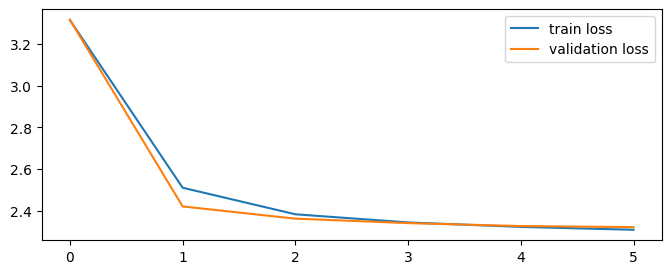

In [32]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=2, hidden_size=128, n_hidden=1, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(0.1)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=5, batch_size=64, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

- Now initial loss much better. Model has approx. equal initial probabilities
- We don't wasting training cycles for fixing initial weights => getting better results within the same epoch count
- model is small, its representation power can be increased to achieve better samples

### Scale-up the model: add neurons to single layer

- scaling up the model will help to achieve better loss value and samples quality
- lets begin with extending embedding size and number of neurons in hidden layer

model384.nelement()=22569
init_t_loss=3.2907557487487793, init_v_loss=3.2889370918273926
epoch=0: cur_avg_train_loss=2.377212243277428, cur_val_loss=2.3123457431793213
epoch=1: cur_avg_train_loss=2.2904441130529114, cur_val_loss=2.292112112045288
epoch=2: cur_avg_train_loss=2.259938746314564, cur_val_loss=2.283400297164917
epoch=3: cur_avg_train_loss=2.240783863490628, cur_val_loss=2.270606279373169
epoch=4: cur_avg_train_loss=2.2283827865190626, cur_val_loss=2.2538366317749023
epoch=5: cur_avg_train_loss=2.2169215121994847, cur_val_loss=2.246901750564575
epoch=6: cur_avg_train_loss=2.2067895962596777, cur_val_loss=2.2339937686920166
epoch=7: cur_avg_train_loss=2.2015186563698474, cur_val_loss=2.239525079727173
epoch=8: cur_avg_train_loss=2.1949574637212392, cur_val_loss=2.2183990478515625
epoch=9: cur_avg_train_loss=2.1893754275450363, cur_val_loss=2.272909164428711

samples:
soyalter.,cay.,eam.,eviostor.,evon.,ensel.,leshany.,matiyah.,ebrode.,liek.,elle.,skyley.,kaeloni.,jeneth.,nyti

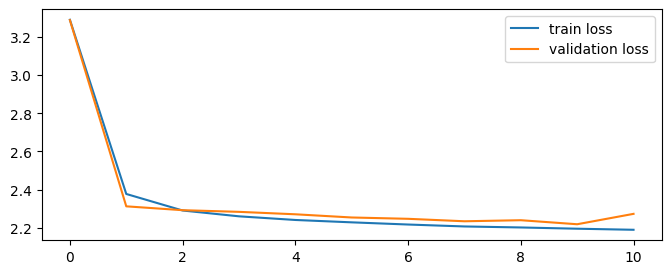

In [35]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=384, n_hidden=1, device=device)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(0.1)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f'{model384.nelement()=}')

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=10, batch_size=64, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

### Scale-up number of layers

- increase number of hidden layers
- visualize activations and gradients at initial state

model.nelement()=73769
init_t_loss=3.304532527923584, init_v_loss=3.3053457736968994
layer 1 (      Tanh): mean +0.01, std 0.92, saturated: 69.12%
layer 3 (      Tanh): mean +0.04, std 0.96, saturated: 85.16%
layer 5 (      Tanh): mean +0.03, std 0.96, saturated: 85.22%
layer 7 (      Tanh): mean -0.04, std 0.96, saturated: 85.07%
layer 9 (      Tanh): mean +0.01, std 0.96, saturated: 84.17%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean -0.000055, std 6.097825e-03
layer 3 (      Tanh): mean -0.000022, std 2.401837e-03
layer 5 (      Tanh): mean -0.000002, std 9.817973e-04
layer 7 (      Tanh): mean -0.000000, std 3.778091e-04
layer 9 (      Tanh): mean -0.000000, std 1.569295e-04
weight   (27, 10) | mean -0.001765 | std 6.383140e-02 | grad:data ratio 6.375358e-02
weight  (30, 128) | mean -0.000022 | std 1.602596e-02 | grad:data ratio 1.601928e-02
weight (128, 128) | mean +0.000032 | std 4.096681e-03 | grad:data ratio 4.038803e-03
weight (128, 128) | m

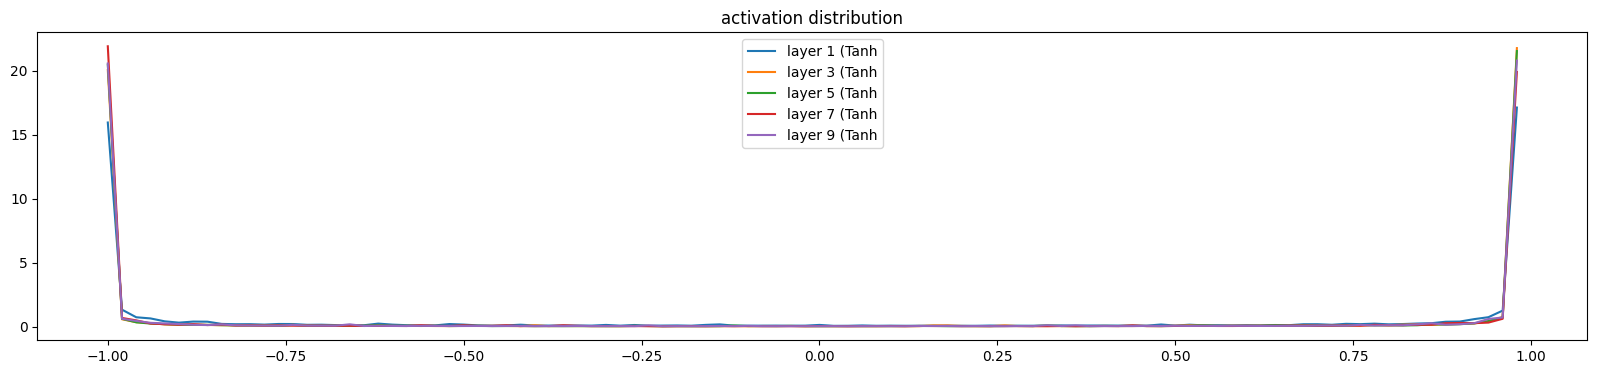

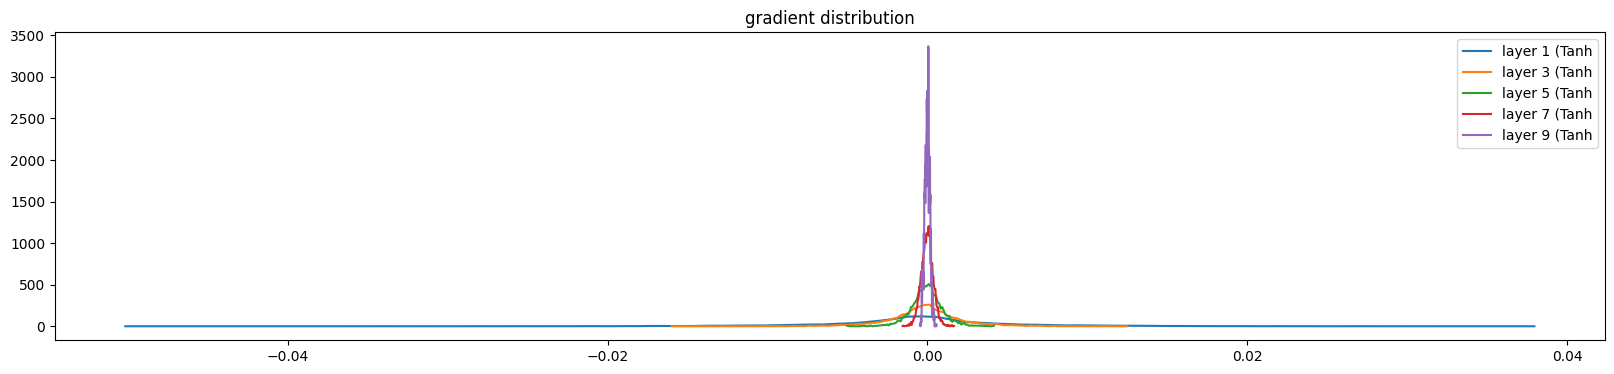

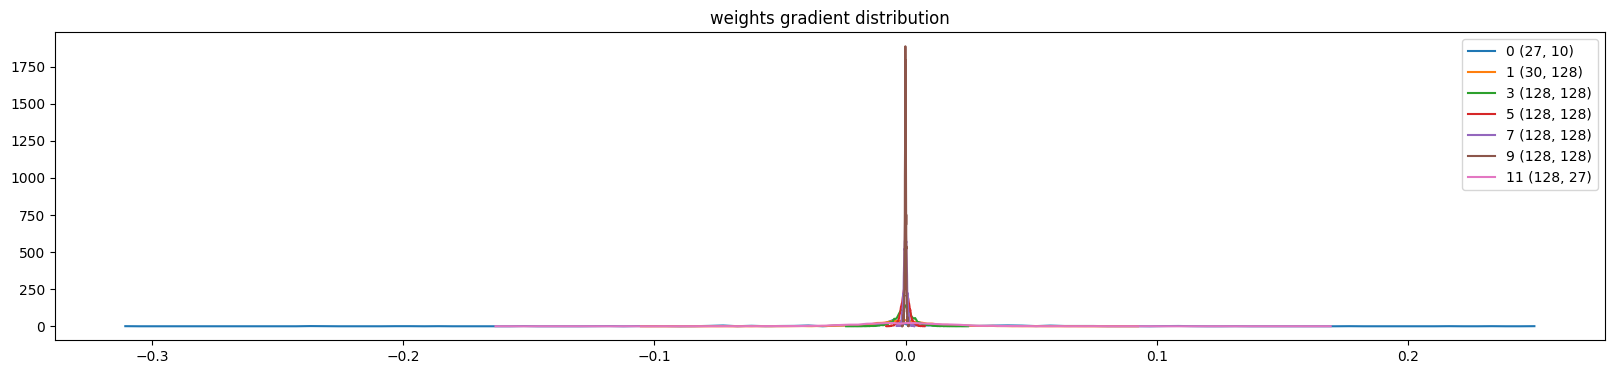

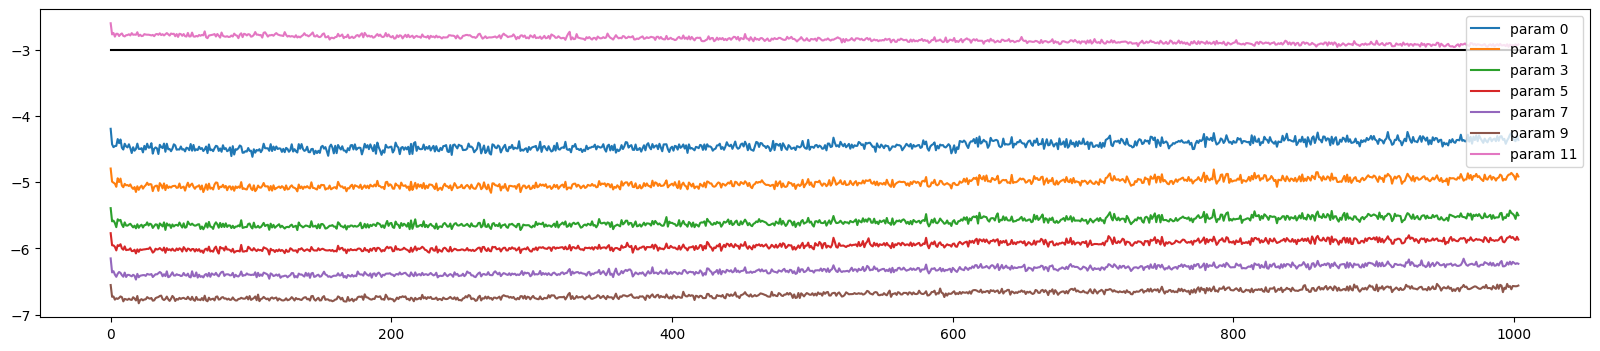

In [36]:
g = torch.Generator(device=device).manual_seed(7877)

model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, keep_intermediate_grad=True, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Given the first plot we see that randomly initialized weights produce almost saturated tanh activations, so gradient signal on backward pass will be to small to learn effectively.
- On the second plot we see the spreading of gradient distribution from last to very first layer (as a result of saturated tanh). It makes first layers difficult to learn as they get small gradient signal. It is called 'gradient vanishing'
- Weights gradients are not well distributed as well (third plot). Last layers have about 10 times bigger gradients, so they learn 10 times faster in the beginning
- Last plot represents update to weight ratio in logarithmic scale. This ratio represents "how big is the value we use to change weight comparing with weight itself". Good value for that ratio is approx -3. Current plot shows at least 4 last parameters which have 10000 times smaller update value in comparison to weight value.

### Final training of model w/o sophisticated initialization

model.nelement()=73769
init_t_loss=3.2973458766937256, init_v_loss=3.2983157634735107
epoch=0: cur_avg_train_loss=3.1555630514177224, cur_val_loss=3.0396907329559326
epoch=1: cur_avg_train_loss=2.961593276838719, cur_val_loss=2.892456293106079
epoch=2: cur_avg_train_loss=2.842572968835726, cur_val_loss=2.7991244792938232
epoch=3: cur_avg_train_loss=2.7637501278760306, cur_val_loss=2.7351949214935303
epoch=4: cur_avg_train_loss=2.7069712096411114, cur_val_loss=2.687502145767212
epoch=5: cur_avg_train_loss=2.6635980144930502, cur_val_loss=2.6493451595306396
epoch=6: cur_avg_train_loss=2.6282401491376244, cur_val_loss=2.6186611652374268
epoch=7: cur_avg_train_loss=2.598791926594104, cur_val_loss=2.592592477798462
epoch=8: cur_avg_train_loss=2.574243952483979, cur_val_loss=2.57080340385437
epoch=9: cur_avg_train_loss=2.5528240874186827, cur_val_loss=2.5513014793395996

samples:
brackjer.,mondiateti.,kasyaeliccre.,ll.,kejeyd.,amajhkeohnaqanqusyvhriaian.,jane.,lanl.,wj.,mahfzerk.,sgq.,beurwa

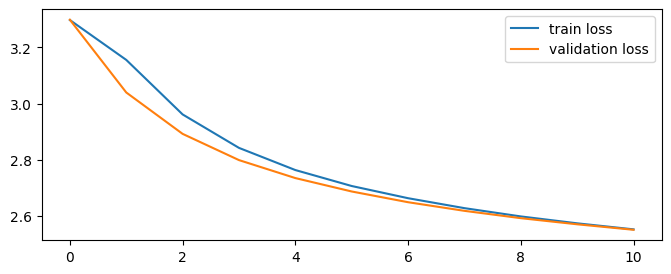

In [39]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=10, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

- ten epoches of training on a 5-layers is worse than the same for single layer model
- thats because of mentioned issues above

### Normalize weights in Linear layer

- next optimizations are from this paper: 'Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)'
- first, we normalize weights using sqrt(fan_in)

model.nelement()=73769
init_t_loss=3.2967209815979004, init_v_loss=3.296809673309326
layer 1 (      Tanh): mean +0.07, std 0.70, saturated: 11.47%
layer 3 (      Tanh): mean +0.03, std 0.68, saturated: 7.34%
layer 5 (      Tanh): mean +0.06, std 0.70, saturated: 9.92%
layer 7 (      Tanh): mean -0.04, std 0.71, saturated: 8.26%
layer 9 (      Tanh): mean -0.10, std 0.63, saturated: 4.73%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean -0.000000, std 2.046340e-06
layer 3 (      Tanh): mean +0.000000, std 3.202369e-06
layer 5 (      Tanh): mean -0.000000, std 5.584312e-06
layer 7 (      Tanh): mean -0.000000, std 9.156717e-06
layer 9 (      Tanh): mean -0.000000, std 1.369045e-05
weight   (27, 10) | mean -0.000001 | std 7.035444e-06 | grad:data ratio 7.444635e-06
weight  (30, 128) | mean -0.000000 | std 1.050889e-05 | grad:data ratio 5.753560e-05
weight (128, 128) | mean +0.000000 | std 1.642016e-05 | grad:data ratio 1.831483e-04
weight (128, 128) | mean 

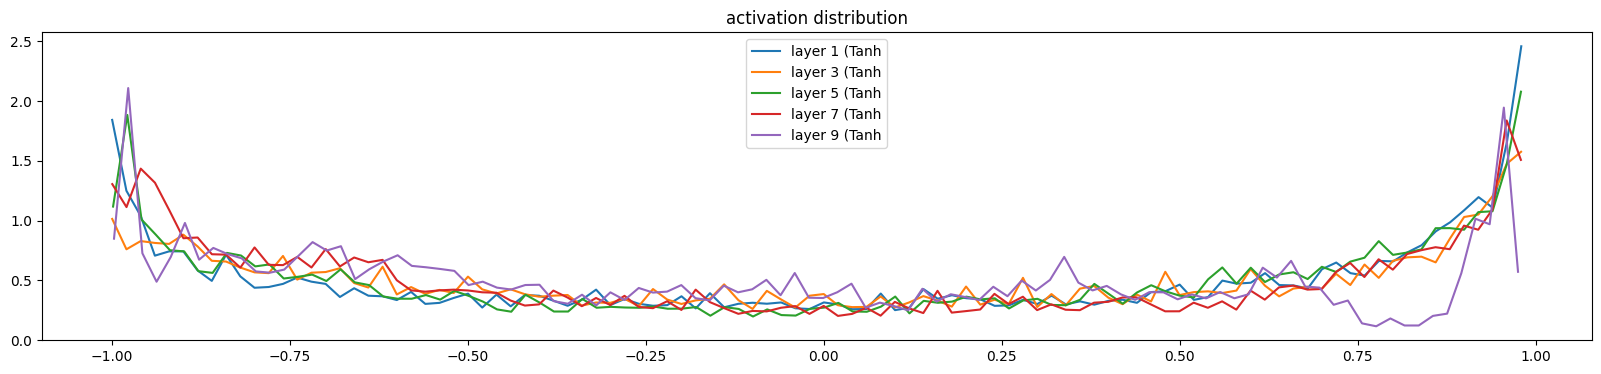

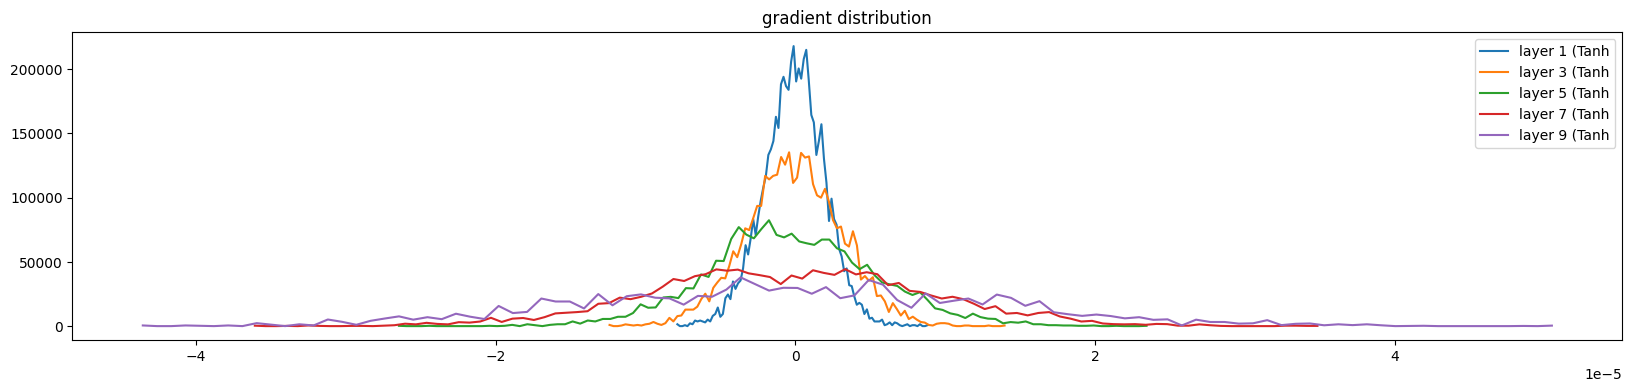

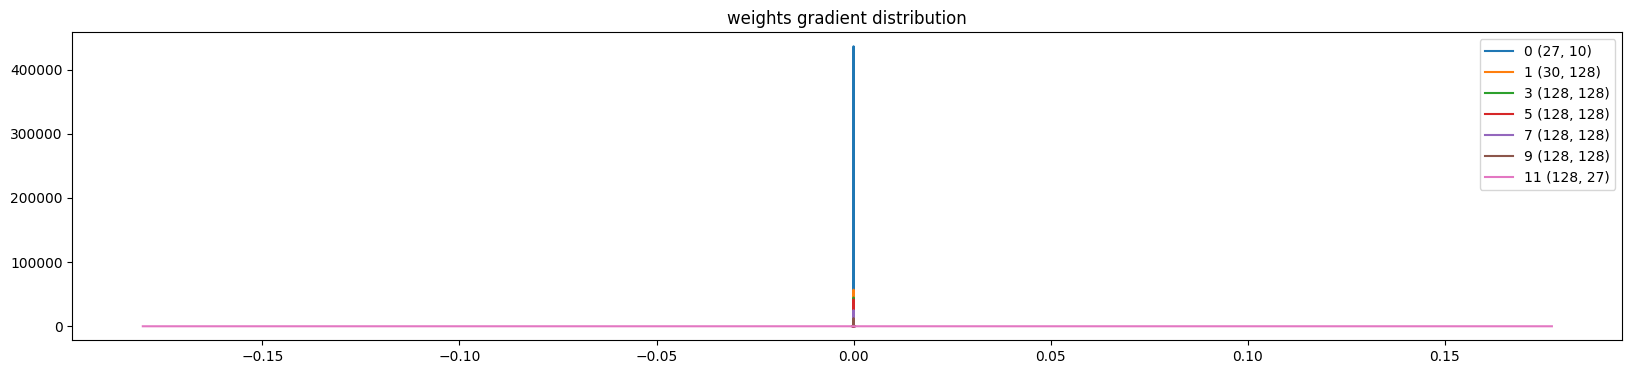

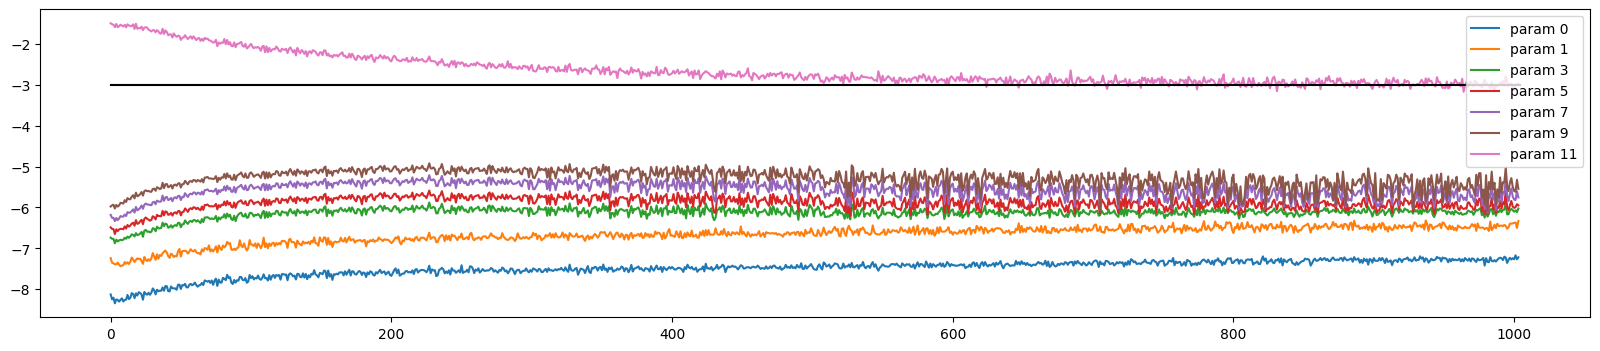

In [49]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, keep_intermediate_grad=True, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")
plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Now activations on tanh saturated only for 5.70%-11.07%. Previously was 69.12%-85.22%
- Better gradient signal will propagate throu the network
- Gradients become better at first layers, but they can be better
- Weights gradients are not well distributed still
- We see that whatever the initialization feature we apply the update:weight ratio still not good enougth. That indicates that we should increase learining rate to make this ratio arrount -3

model.nelement()=73769
init_t_loss=3.2951667308807373, init_v_loss=3.2951581478118896
epoch=0: cur_avg_train_loss=2.930444522488747, cur_val_loss=2.8362443447113037
epoch=1: cur_avg_train_loss=2.832924221947804, cur_val_loss=2.817181348800659
epoch=2: cur_avg_train_loss=2.822046379743521, cur_val_loss=2.8091981410980225
epoch=3: cur_avg_train_loss=2.814845742637353, cur_val_loss=2.801945209503174
epoch=4: cur_avg_train_loss=2.8065339458785052, cur_val_loss=2.792381763458252
epoch=5: cur_avg_train_loss=2.79501053034249, cur_val_loss=2.779109001159668
epoch=6: cur_avg_train_loss=2.779545835340962, cur_val_loss=2.7619924545288086
epoch=7: cur_avg_train_loss=2.7612098556453897, cur_val_loss=2.7437658309936523
epoch=8: cur_avg_train_loss=2.743399594383962, cur_val_loss=2.727492094039917
epoch=9: cur_avg_train_loss=2.7283607755796027, cur_val_loss=2.714221239089966
epoch=10: cur_avg_train_loss=2.7162426708940255, cur_val_loss=2.7035908699035645
epoch=11: cur_avg_train_loss=2.706482648136371,

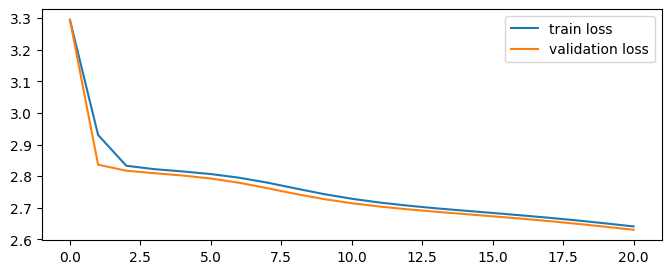

In [50]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

- Results still can be better
- unusual behaviour of loss is related to optimization algo (SGD)

### Increase learning rate

- given update:weight ratio plots we see that learning rate can be increased slightly to make update:weight ~ 1:1000
- according to last plot we can make a learning_rate for last model 10-100 times bigger

model.nelement()=73769
init_t_loss=3.2967538833618164, init_v_loss=3.296842098236084
layer 1 (      Tanh): mean +0.04, std 0.71, saturated: 11.80%
layer 3 (      Tanh): mean +0.03, std 0.68, saturated: 7.56%
layer 5 (      Tanh): mean +0.05, std 0.70, saturated: 9.73%
layer 7 (      Tanh): mean -0.05, std 0.71, saturated: 8.81%
layer 9 (      Tanh): mean -0.10, std 0.63, saturated: 5.54%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean +0.000000, std 2.103664e-06
layer 3 (      Tanh): mean -0.000000, std 3.276032e-06
layer 5 (      Tanh): mean +0.000000, std 5.682575e-06
layer 7 (      Tanh): mean -0.000000, std 9.416903e-06
layer 9 (      Tanh): mean +0.000000, std 1.399982e-05
weight   (27, 10) | mean +0.000000 | std 7.277436e-06 | grad:data ratio 7.722926e-06
weight  (30, 128) | mean +0.000000 | std 9.708115e-06 | grad:data ratio 5.315138e-05
weight (128, 128) | mean -0.000000 | std 1.589797e-05 | grad:data ratio 1.773239e-04
weight (128, 128) | mean 

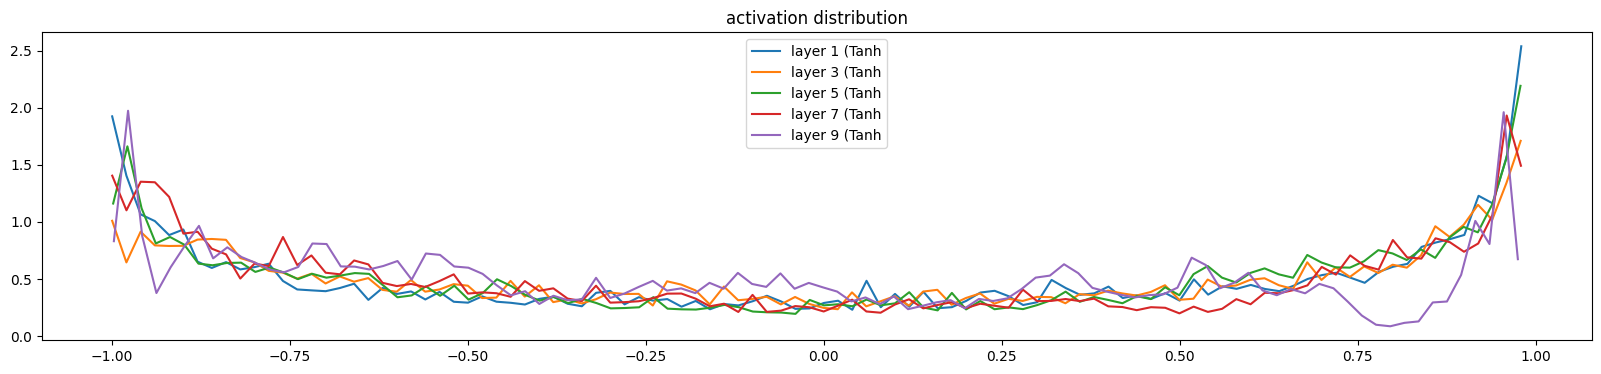

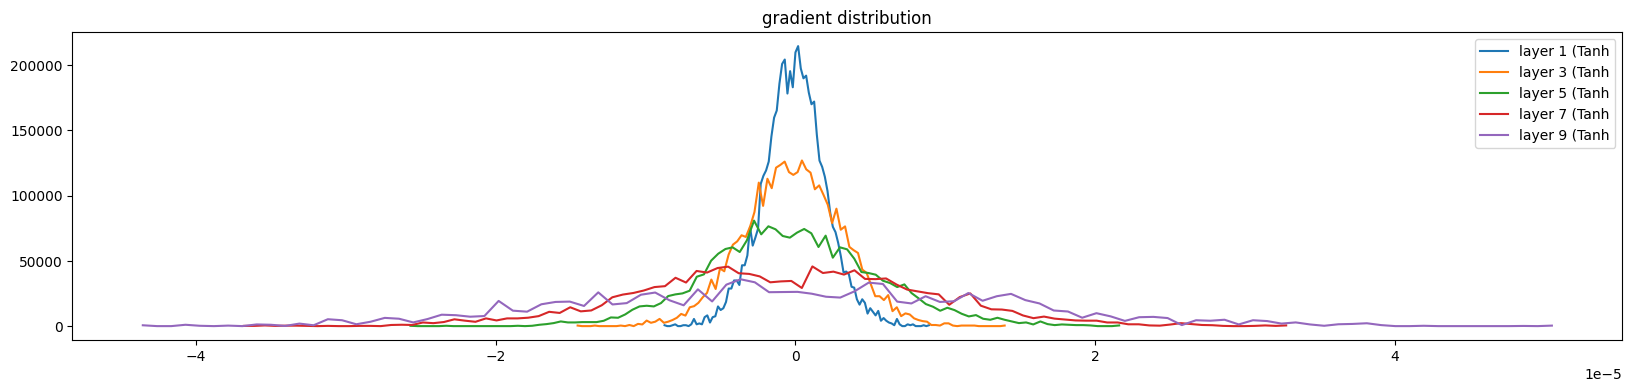

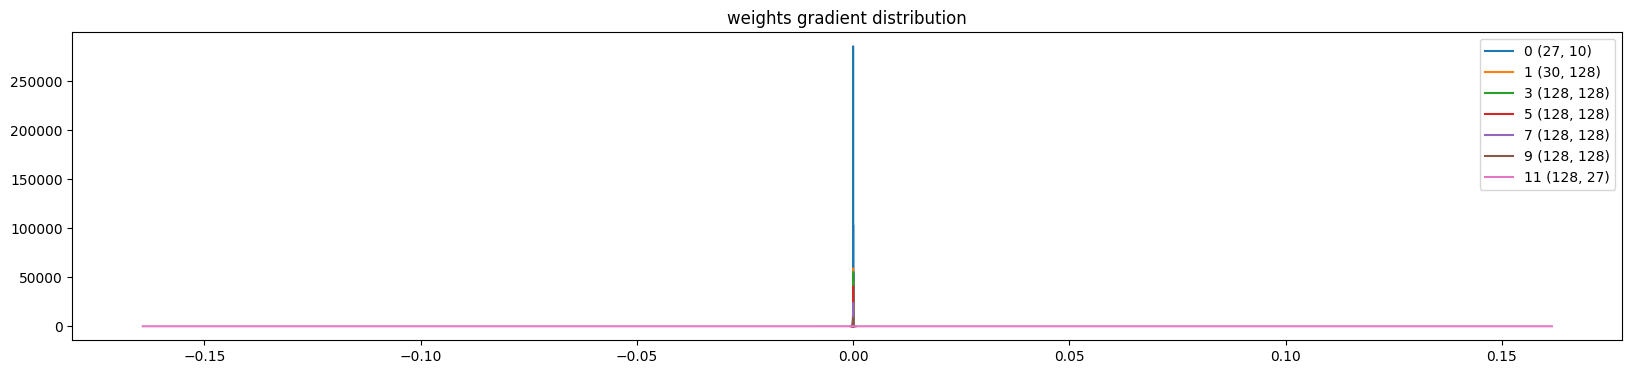

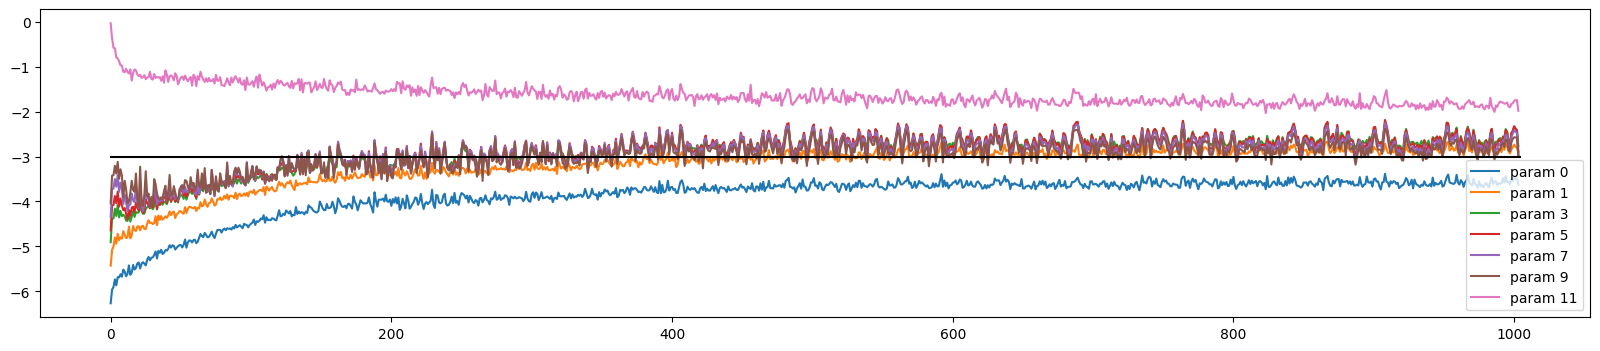

In [51]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, keep_intermediate_grad=True, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- After few manual runs I found that 7e-2 Is a good one, so it 70 times bigger than previous value
- Now learning rate provides better update:weight ratio
- model still experiencing gradient issues

model.nelement()=73769
init_t_loss=3.2950663566589355, init_v_loss=3.295053243637085
epoch=0: cur_avg_train_loss=2.5997737628274997, cur_val_loss=2.465555429458618
epoch=1: cur_avg_train_loss=2.386251583175431, cur_val_loss=2.3252065181732178
epoch=2: cur_avg_train_loss=2.306150321589629, cur_val_loss=2.282615900039673
epoch=3: cur_avg_train_loss=2.2682038653764507, cur_val_loss=2.25584077835083
epoch=4: cur_avg_train_loss=2.2410020715336976, cur_val_loss=2.234511613845825
epoch=5: cur_avg_train_loss=2.220178636216214, cur_val_loss=2.2188782691955566
epoch=6: cur_avg_train_loss=2.203409213962726, cur_val_loss=2.2037272453308105
epoch=7: cur_avg_train_loss=2.1890833590584524, cur_val_loss=2.1986241340637207
epoch=8: cur_avg_train_loss=2.1764389214701096, cur_val_loss=2.192186117172241
epoch=9: cur_avg_train_loss=2.1648668917202403, cur_val_loss=2.177415132522583
epoch=10: cur_avg_train_loss=2.1540883564402313, cur_val_loss=2.1678953170776367
epoch=11: cur_avg_train_loss=2.14530785145574

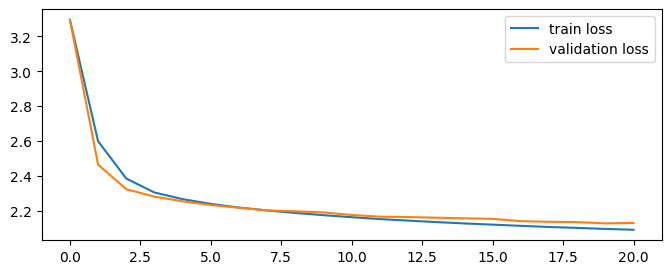

In [52]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

- better loss results, samples are become better

### Complete calculating the init scale (Kaiming init): adding gain
- for details: 'Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)'
- at last activation plots we saw that gradients distribution is 'shrinking' from last to fisrt layers.
- at initialization we want to maintain distribution of activations on each layer with same mean and std. Its can be done by initialization of linear layer weights by sampling N(0,std^2) where std = gain/sqrt(in_features)

model.nelement()=73769
init_t_loss=3.3245530128479004, init_v_loss=3.325197458267212
layer 1 (      Tanh): mean -0.00, std 0.80, saturated: 29.41%
layer 3 (      Tanh): mean +0.01, std 0.75, saturated: 20.18%
layer 5 (      Tanh): mean +0.05, std 0.76, saturated: 20.64%
layer 7 (      Tanh): mean -0.07, std 0.76, saturated: 21.86%
layer 9 (      Tanh): mean -0.09, std 0.72, saturated: 18.09%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean +0.000001, std 1.693037e-04
layer 3 (      Tanh): mean -0.000002, std 1.812355e-04
layer 5 (      Tanh): mean +0.000001, std 2.061614e-04
layer 7 (      Tanh): mean -0.000000, std 2.283788e-04
layer 9 (      Tanh): mean -0.000003, std 2.333606e-04
weight   (27, 10) | mean +0.000043 | std 7.760762e-04 | grad:data ratio 8.071642e-04
weight  (30, 128) | mean -0.000001 | std 7.032578e-04 | grad:data ratio 2.310178e-03
weight (128, 128) | mean -0.000001 | std 7.039586e-04 | grad:data ratio 4.711123e-03
weight (128, 128) | m

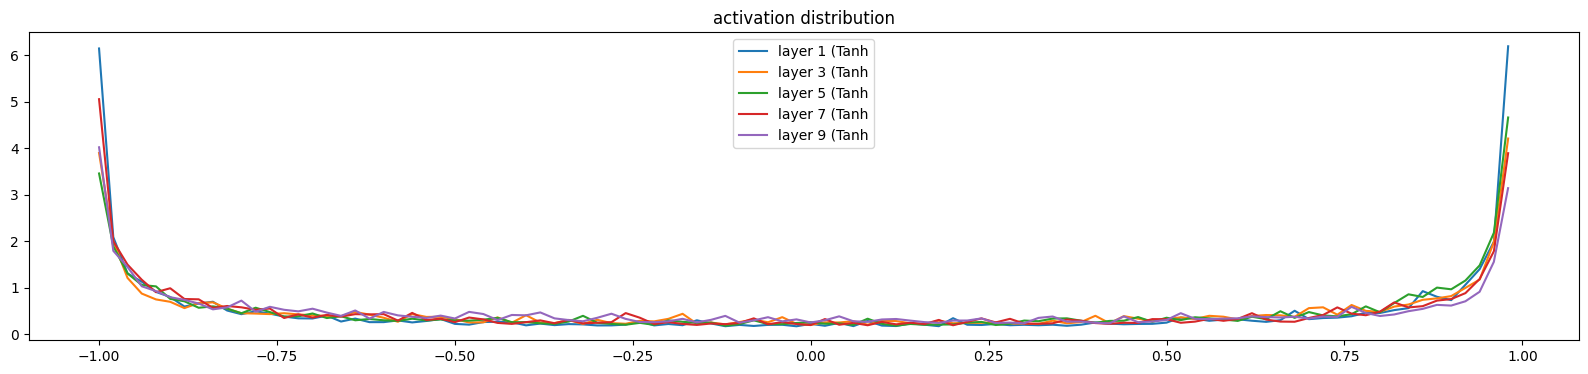

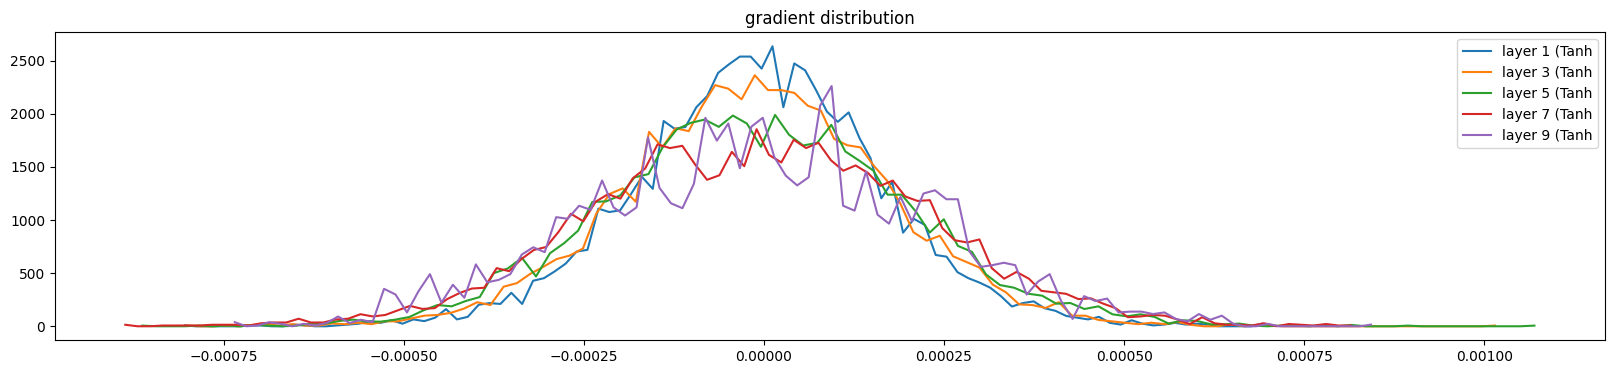

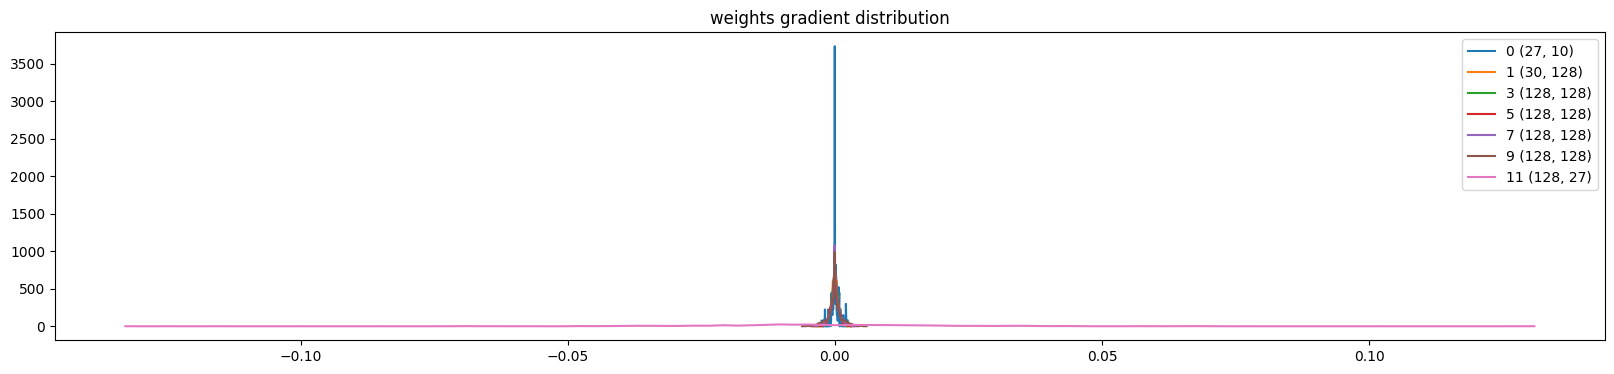

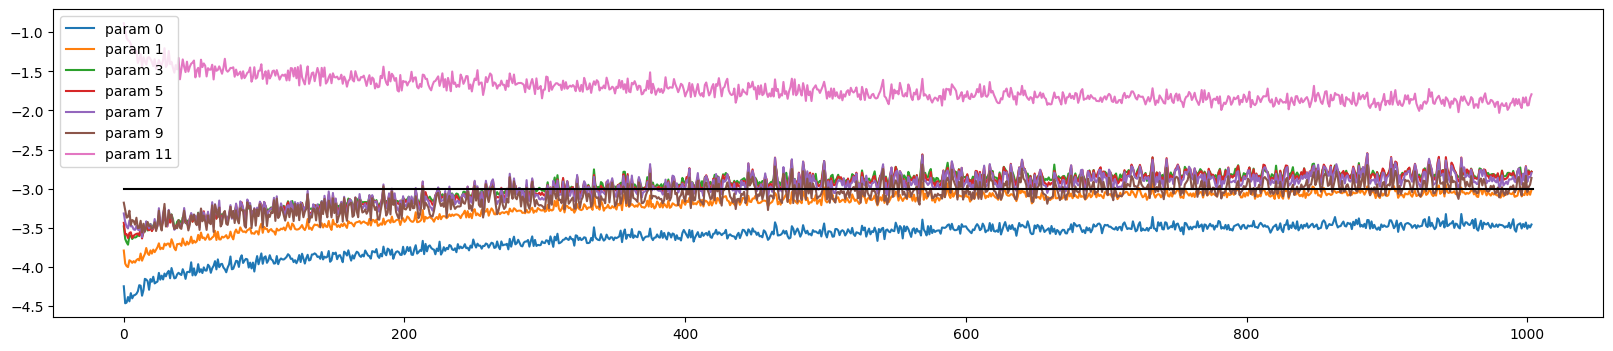

In [62]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearWithGain, keep_intermediate_grad=True, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.1
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")
plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Gradients per layer distributed very well
- Weights gradients are good enougth

model.nelement()=73769
init_t_loss=3.2964096069335938, init_v_loss=3.296566963195801
epoch=0: cur_avg_train_loss=2.480708705760319, cur_val_loss=2.3501346111297607
epoch=1: cur_avg_train_loss=2.311889750425812, cur_val_loss=2.2759768962860107
epoch=2: cur_avg_train_loss=2.2550155537994514, cur_val_loss=2.2359912395477295
epoch=3: cur_avg_train_loss=2.2197856373071336, cur_val_loss=2.2158706188201904
epoch=4: cur_avg_train_loss=2.1954194643387117, cur_val_loss=2.192528247833252
epoch=5: cur_avg_train_loss=2.1765388126627427, cur_val_loss=2.1861867904663086
epoch=6: cur_avg_train_loss=2.160352033953513, cur_val_loss=2.1753435134887695
epoch=7: cur_avg_train_loss=2.1474544796335078, cur_val_loss=2.16410493850708
epoch=8: cur_avg_train_loss=2.1364327276237884, cur_val_loss=2.159529685974121
epoch=9: cur_avg_train_loss=2.1266981535506284, cur_val_loss=2.1517515182495117
epoch=10: cur_avg_train_loss=2.118594662504477, cur_val_loss=2.143815040588379
epoch=11: cur_avg_train_loss=2.110154921844

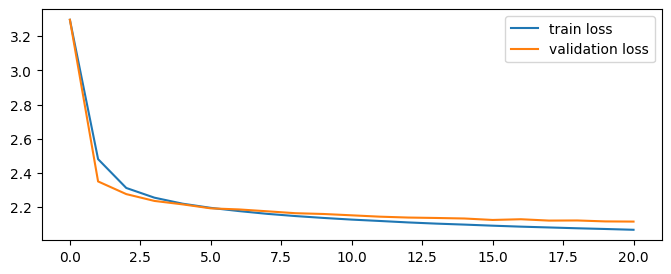

In [64]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearWithGain, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=256, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

- way better results

### Test evaluation

In [66]:
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')


test_loss=tensor(2.1085)


### Scale-up model to extrieme case)

- lets build e.g. 30-layer and see if we are able to train such a big model
- lets also increase context to the maximum value available

In [65]:
max(map(lambda name: len(name), names))

15

In [5]:
block_size_15 = 15

train_X, train_y = build_names_dataset(names[:train_bound], tokenizer, block_size_15)
val_X, val_y = build_names_dataset(names[train_bound:val_bound], tokenizer, block_size_15)
test_X, test_y = build_names_dataset(names[val_bound:], tokenizer, block_size_15)
print(f'{train_X.shape=}, {train_y.shape=}, {val_X.shape=}, {val_y.shape=}, {test_X.shape=}, {test_y.shape=}')
print("train:")
for i in range(13):
    print(f'{"".join(tokenizer.decode(train_X[i]))} => {tokenizer.itoc[train_y[i]]}')

train_ds = TensorDataset(train_X, train_y)
val_ds   = TensorDataset(val_X, val_y, device)

train_X.shape=torch.Size([182412, 15]), train_y.shape=torch.Size([182412]), val_X.shape=torch.Size([22894, 15]), val_y.shape=torch.Size([22894]), test_X.shape=torch.Size([22840, 15]), test_y.shape=torch.Size([22840])
train:
............... => r
..............r => e
.............re => e
............ree => s
...........rees => e
..........reese => .
............... => o
..............o => r
.............or => e
............ore => o
...........oreo => l
..........oreol => u
.........oreolu => w


model.nelement()=501929
init_t_loss=3.287630558013916, init_v_loss=3.288296699523926
layer 1 (      Tanh): mean +0.01, std 0.77, saturated: 24.62%
layer 3 (      Tanh): mean +0.05, std 0.77, saturated: 22.10%
layer 5 (      Tanh): mean +0.12, std 0.74, saturated: 20.60%
layer 7 (      Tanh): mean -0.03, std 0.75, saturated: 17.72%
layer 9 (      Tanh): mean -0.09, std 0.73, saturated: 17.52%
layer 11 (      Tanh): mean +0.08, std 0.73, saturated: 15.22%
layer 13 (      Tanh): mean -0.00, std 0.75, saturated: 20.70%
layer 15 (      Tanh): mean +0.07, std 0.78, saturated: 19.42%
layer 17 (      Tanh): mean -0.08, std 0.75, saturated: 19.39%
layer 19 (      Tanh): mean +0.10, std 0.75, saturated: 18.22%
layer 21 (      Tanh): mean +0.07, std 0.73, saturated: 17.48%
layer 23 (      Tanh): mean +0.06, std 0.72, saturated: 12.95%
layer 25 (      Tanh): mean +0.02, std 0.79, saturated: 23.01%
layer 27 (      Tanh): mean +0.07, std 0.76, saturated: 22.49%
layer 29 (      Tanh): mean -0.03, std

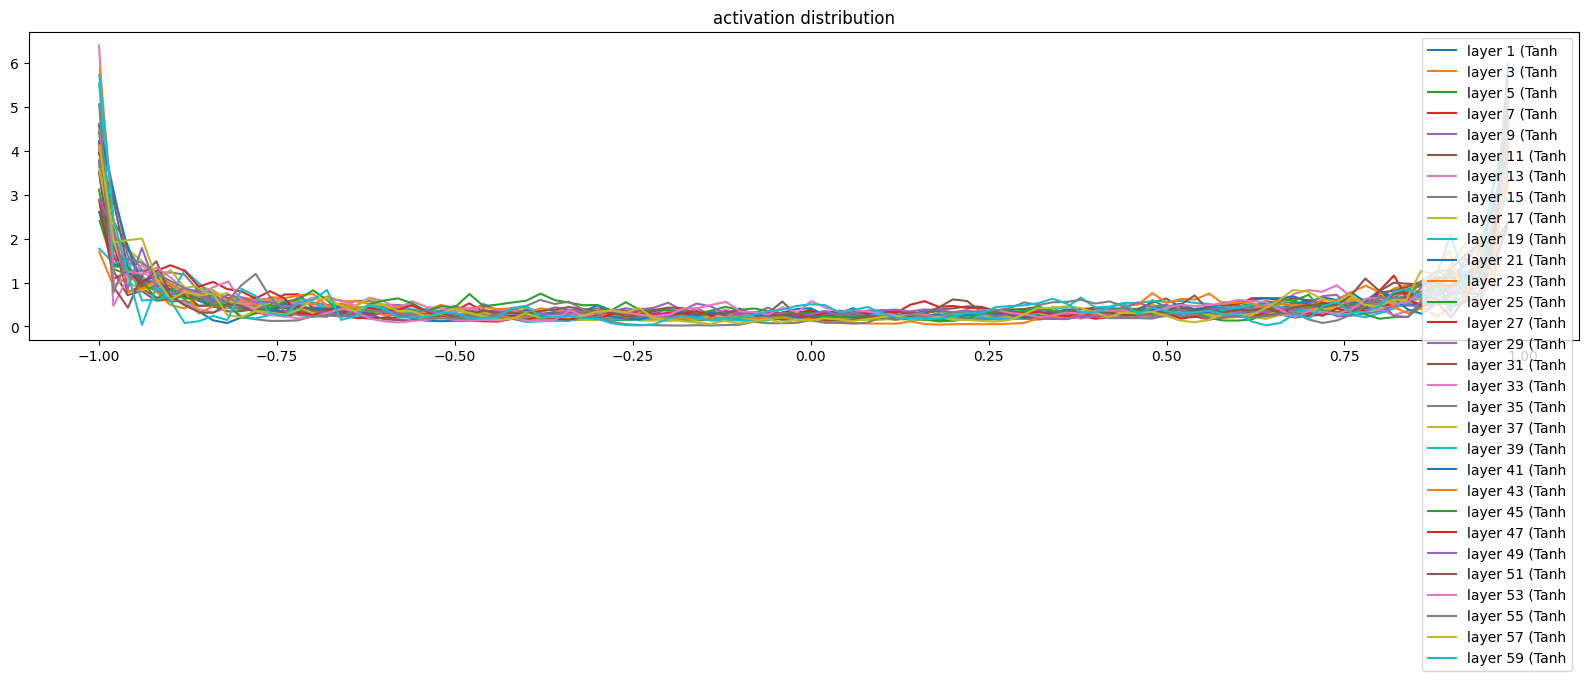

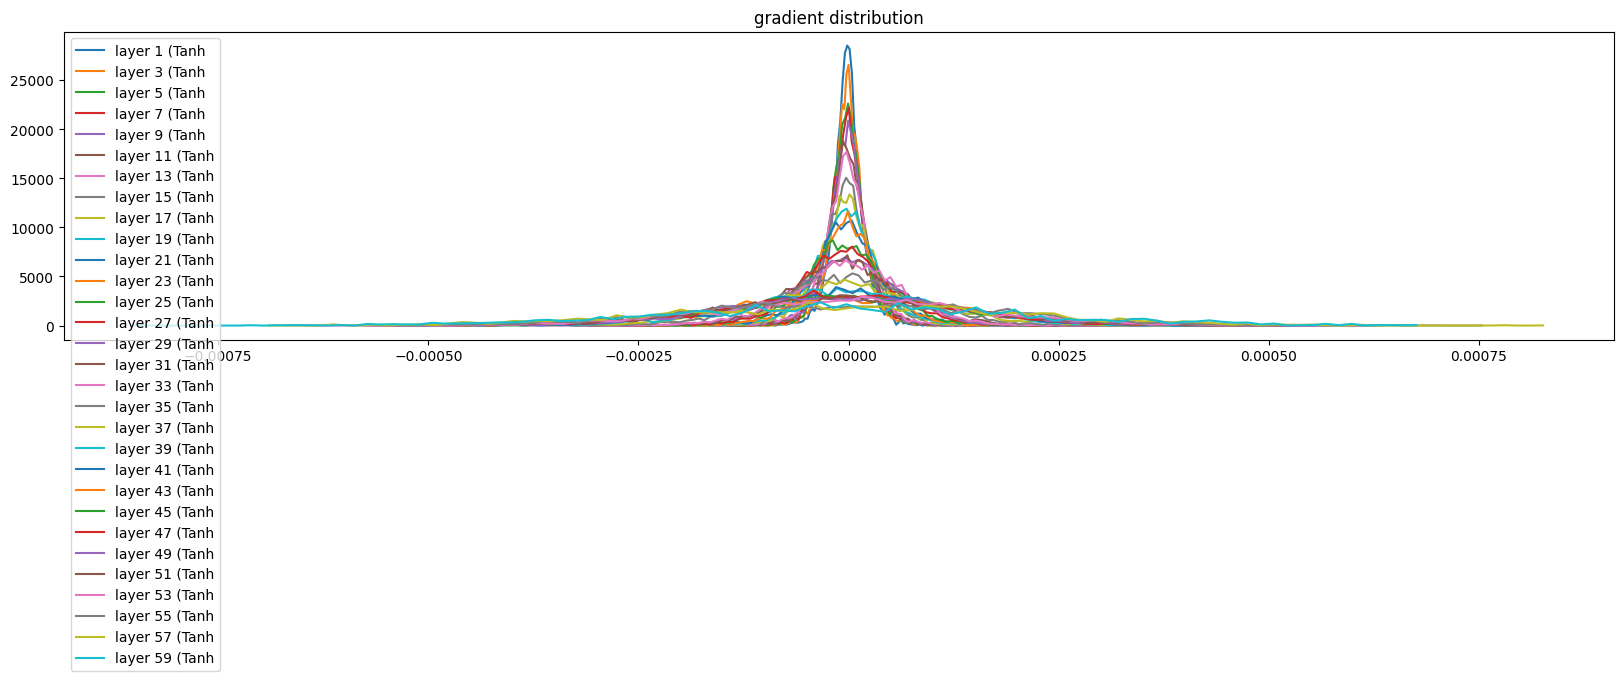

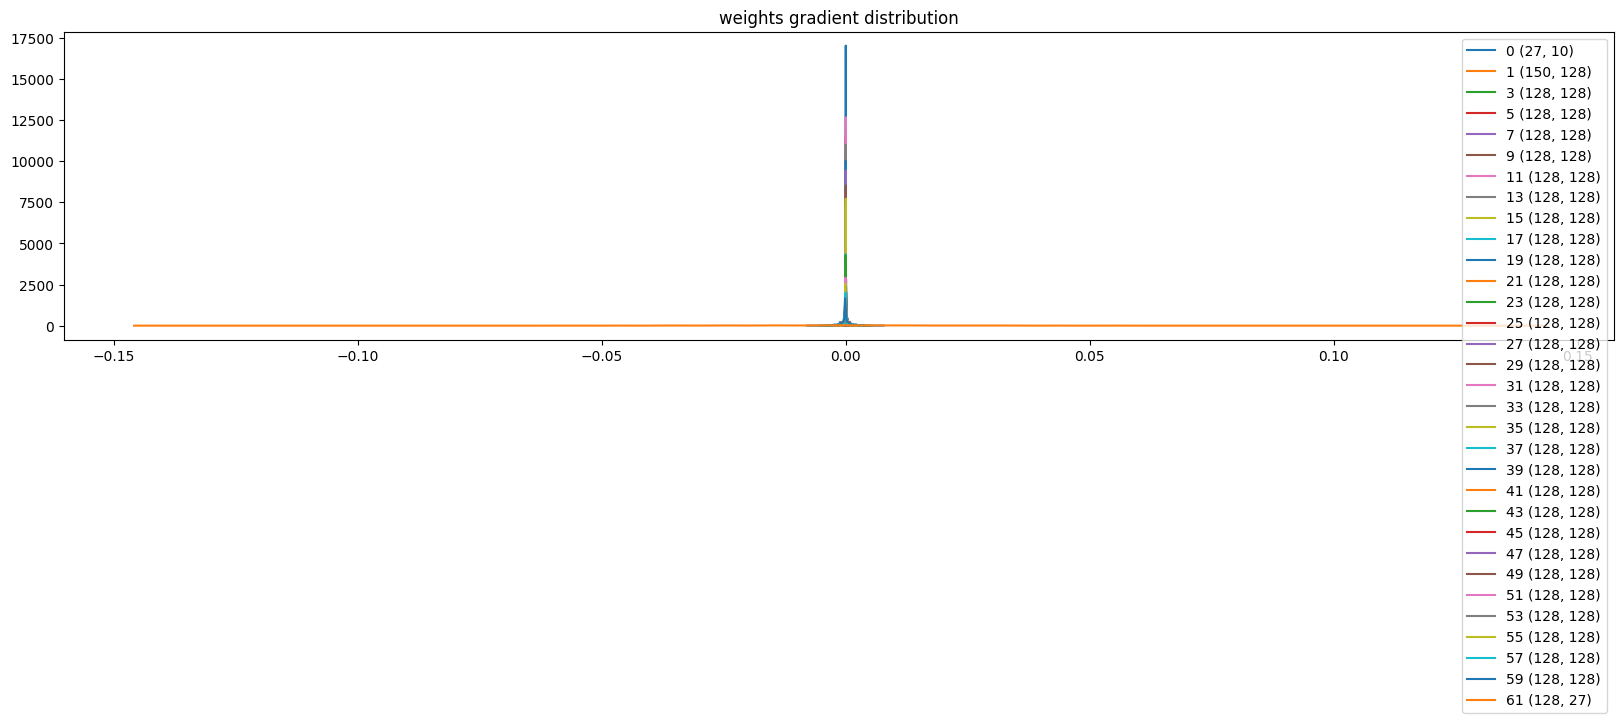

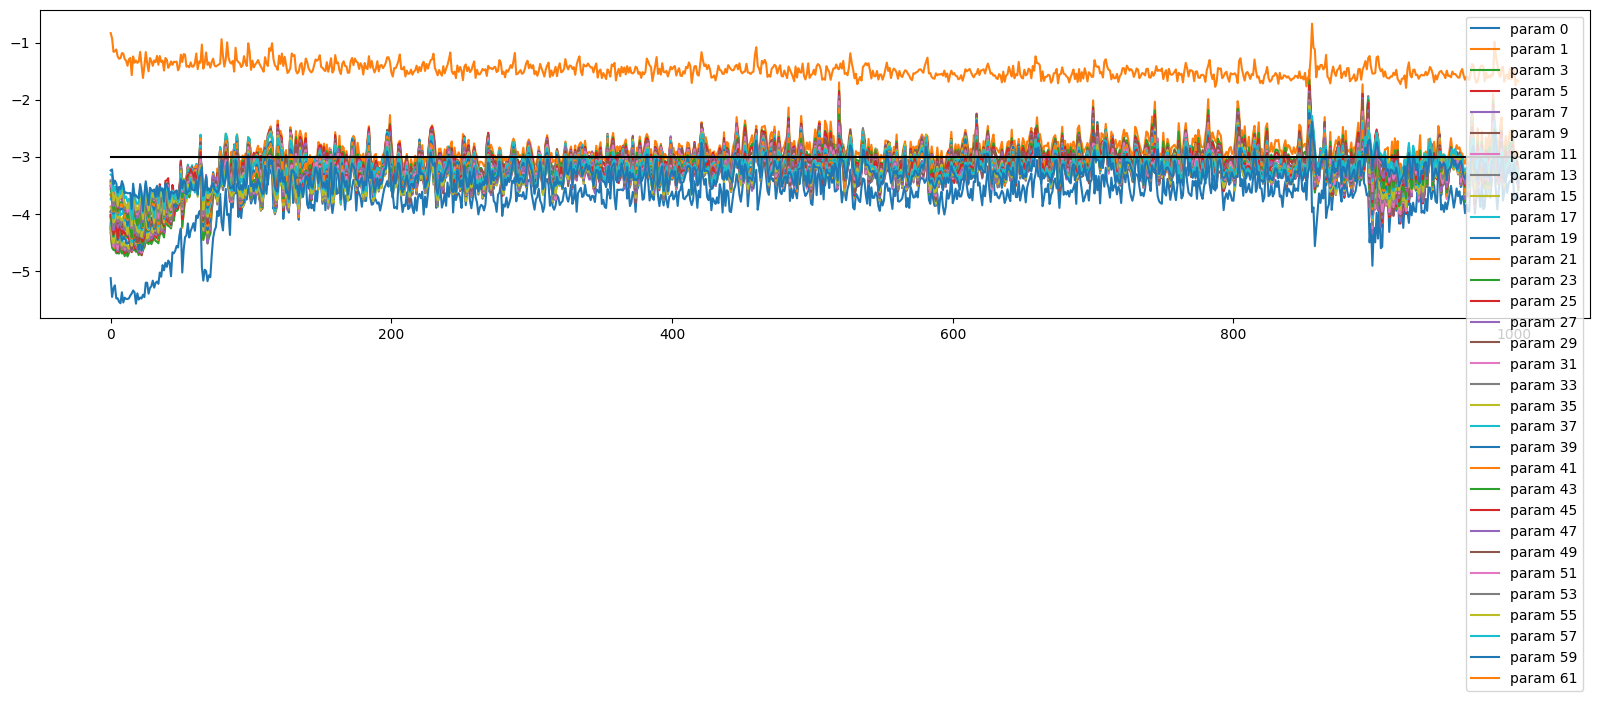

In [9]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size_15, emb_size=10, hidden_size=128, n_hidden=30, linear_layer=LinearWithGain, keep_intermediate_grad=True, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.1
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")
plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

model.nelement()=486569
init_t_loss=3.2944552898406982, init_v_loss=3.294430732727051
epoch=0: cur_avg_train_loss=2.6533084196596293, cur_val_loss=2.505636215209961
epoch=1: cur_avg_train_loss=2.4448330205085402, cur_val_loss=2.4095418453216553
epoch=2: cur_avg_train_loss=2.38024533580764, cur_val_loss=2.3607187271118164
epoch=3: cur_avg_train_loss=2.327831484325136, cur_val_loss=2.3224709033966064
epoch=4: cur_avg_train_loss=2.2901319180096684, cur_val_loss=2.30840802192688
epoch=5: cur_avg_train_loss=2.2634030990145817, cur_val_loss=2.2679951190948486
epoch=6: cur_avg_train_loss=2.239838792598933, cur_val_loss=2.2588858604431152
epoch=7: cur_avg_train_loss=2.220835084834908, cur_val_loss=2.240757703781128
epoch=8: cur_avg_train_loss=2.2089549883217834, cur_val_loss=2.2234716415405273
epoch=9: cur_avg_train_loss=2.193767748072973, cur_val_loss=2.2185120582580566
epoch=10: cur_avg_train_loss=2.1818612874139407, cur_val_loss=2.2175521850585938
epoch=11: cur_avg_train_loss=2.171486041321

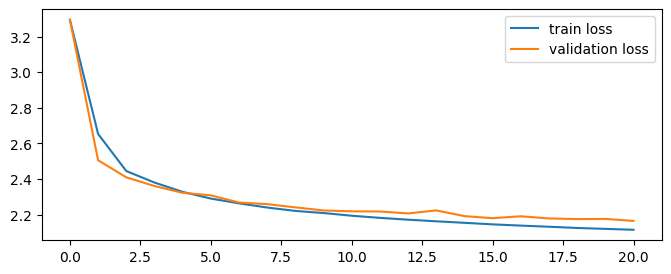

In [6]:
g = torch.Generator(device=device).manual_seed(7877)

# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=30, linear_layer=LinearWithGain, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=256, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)

### Test evaluation

In [7]:
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')


test_loss=tensor(2.1307)


### Now 20  wider layers

model.nelement()=745293
init_t_loss=3.2953455448150635, init_v_loss=3.2953031063079834
epoch=0: cur_avg_train_loss=2.4219883940375815, cur_val_loss=2.3034632205963135
epoch=1: cur_avg_train_loss=2.2825381373723683, cur_val_loss=2.277949094772339
epoch=2: cur_avg_train_loss=2.2404104686297597, cur_val_loss=2.227875232696533
epoch=3: cur_avg_train_loss=2.2129501383199663, cur_val_loss=2.2017698287963867
epoch=4: cur_avg_train_loss=2.1920862966684966, cur_val_loss=2.194446325302124
epoch=5: cur_avg_train_loss=2.1764012470634992, cur_val_loss=2.168039560317993
epoch=6: cur_avg_train_loss=2.16186033523482, cur_val_loss=2.1756510734558105
epoch=7: cur_avg_train_loss=2.1529609645727787, cur_val_loss=2.183729648590088
epoch=8: cur_avg_train_loss=2.1426072533289924, cur_val_loss=2.1571671962738037
epoch=9: cur_avg_train_loss=2.135441631637873, cur_val_loss=2.1701204776763916
epoch=10: cur_avg_train_loss=2.1278992940224453, cur_val_loss=2.1641483306884766
epoch=11: cur_avg_train_loss=2.120679217

NameError: name 'print_samples' is not defined

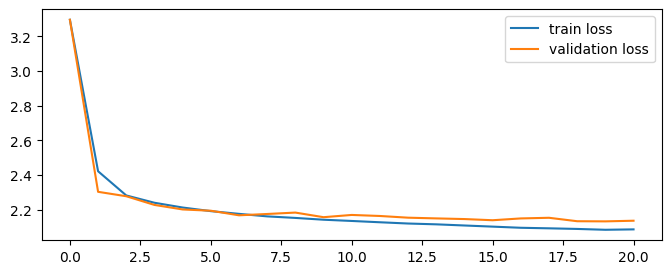

In [4]:
g = torch.Generator(device=device).manual_seed(7877)

# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=196, n_hidden=20, linear_layer=LinearWithGain, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=32, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

print_samples(model, tokenizer, n_samples=15)